In [1]:
# !wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/wg4bpm33hj-2.zip

In [2]:
# !unzip /content/wg4bpm33hj-2.zip

## 文件預處理

In [3]:
# import zipfile
# import os

# def extract_zip_flat(zip_path, output_folder):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         for file_info in zip_ref.infolist():
#             # 忽略目錄
#             if file_info.is_dir():
#                 continue
#             # 提取文件
#             extracted_path = zip_ref.extract(file_info, output_folder)
#             # 構造目標文件路徑
#             destination_path = os.path.join(output_folder, os.path.basename(file_info.filename))
#             # 如果目標文件已存在，先刪除
#             if os.path.exists(destination_path):
#                 os.remove(destination_path)
#             # 重命名文件
#             os.rename(extracted_path, destination_path)
#             # 如果提取出的路徑是目錄，則刪除（這是提取出的文件的臨時目錄）
#             if os.path.isdir(extracted_path):
#                 os.rmdir(extracted_path)

# def extract_all_zips_in_folder(source_folder, target_folder):
#     for zip_filename in os.listdir(source_folder):
#         if zip_filename.endswith('.zip'):
#             zip_filepath = os.path.join(source_folder, zip_filename)
#             extract_zip_flat(zip_filepath, target_folder)

# # 指定包含 ZIP 文件的源文件夾和目標文件夾路徑
# source_image_folder = 'wg4bpm33hj-2/images'  # ZIP 文件所在的文件夾
# source_mask_folder = 'wg4bpm33hj-2/masks'  # ZIP 文件所在的文件夾
# target_image_folder = 'ds/extracted_images'  # 解壓縮後的圖像存放路徑
# target_mask_folder = 'ds/extracted_masks'  # 解壓縮後的掩膜存放路徑

# # 解壓縮圖像和掩膜
# extract_all_zips_in_folder(source_image_folder, target_image_folder)
# extract_all_zips_in_folder(source_mask_folder, target_mask_folder)

In [4]:
# import shutil
# # 起始和结束的文件夹名
# start_folder = 'A'
# end_folder = 'O'


# # 循环删除从 A 到 O 的每个文件夹
# for folder_name in range(ord(start_folder), ord(end_folder) + 1):
#     folder1 = 'DL/HW5/ds/extracted_images/'+chr(folder_name)
#     folder2 = 'DL/HW5/ds/extracted_masks/'+chr(folder_name)
#     if os.path.exists(folder1) and os.path.isdir(folder1):
#         shutil.rmtree(folder1)
#         print(f"Folder '{folder1}' has been deleted.")
#     else:
#         print(f"Folder '{folder1}' does not exist or is not a directory.")
#     if os.path.exists(folder2) and os.path.isdir(folder2):
#         shutil.rmtree(folder2)
#         print(f"Folder '{folder2}' has been deleted.")


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from tqdm.notebook import tqdm

## Dataset

In [28]:
import os
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np

class CCAgTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.filenames = [os.path.splitext(filename)[0] for filename in os.listdir(image_dir)
                          if filename.endswith('.jpg') and not filename.startswith('.')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.image_dir, img_name + '.jpg')
        mask_path = os.path.join(self.mask_dir, img_name + '.png')
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Mask as a single channel image

        
#         print("Before transform:", type(image), type(mask))  # Debugging

        if self.transforms:
            transformed = self.transforms(image=np.array(image), mask=np.array(mask))
            image = transformed['image']
            mask = transformed['mask']

#         print("After transform:", type(image), type(mask))  # Debugging
#         print("Tensor types:", image.dtype, mask.dtype)    # Check tensor datatypes
#         # Convert to tensor
#         image = transforms.ToTensor()(image)
#         mask = torch.tensor(np.array(mask), dtype=torch.long)  # Assuming mask has integer labels
        image = image.float() / 255.0
#         mask = mask.long()
        return image, mask

# Define joint transformations
from albumentations import Compose, Resize, ColorJitter, RandomBrightnessContrast, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2

joint_transforms = Compose([
    Resize(800, 800),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), p=0.5),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ToTensorV2()  # This will be handled separately due to different data types of image and mask
])

# Create dataset instance
dataset = CCAgTDataset('ds/extracted_images', 'ds/extracted_masks', transforms=joint_transforms)

# Split the dataset into training, validation, and test sets
total_count = len(dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.1 * total_count)
test_count = total_count - train_count - valid_count

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_count, valid_count, test_count])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=6)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=6)


In [29]:
!nvdia-smi

/bin/dash: 1: nvdia-smi: not found


In [30]:
for idx in range(len(dataset)):
    img_name = dataset.filenames[idx]
    img_path = os.path.join(dataset.image_dir, img_name + '.jpg')
    mask_path = os.path.join(dataset.mask_dir, img_name + '.png')
    
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
    if not os.path.exists(mask_path):
        print(f"Mask not found: {mask_path}")

In [31]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))
sum([len(train_dataset), len(valid_dataset), len(test_dataset)])


6537 933 1869


9339

torch.float32


(-0.5, 799.5, 799.5, -0.5)

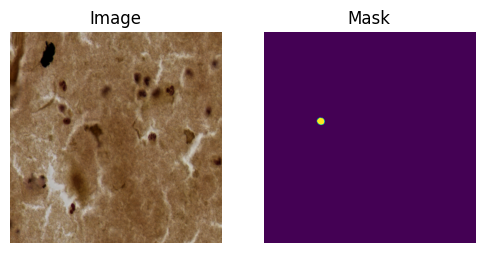

In [32]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Load a single data sample
image, mask = train_dataset[35]
print(image.dtype)
# Visualize the image
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(TF.to_pil_image(image))
plt.title("Image")
plt.axis("off")

# Visualize the mask
plt.subplot(1, 2, 2)
plt.imshow(TF.to_pil_image(mask))
plt.title("Mask")
plt.axis("off")
# Assuming the mask is a single-channel tensor, you should convert it to a numpy array for visualization
# The permute method is used to reorder the dimensions from CxHxW to HxWxC


torch.Size([800, 800])
torch.Size([800, 800])
3
Unique values in transformed tensor: tensor([0, 1, 2, 3], dtype=torch.uint8)


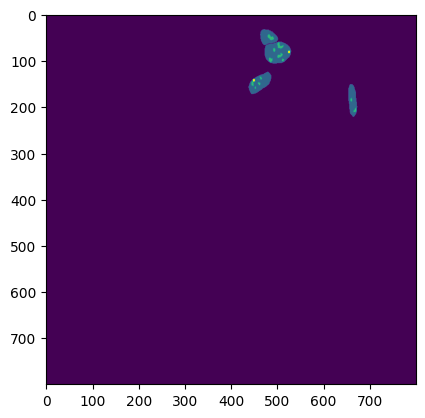

In [33]:
import matplotlib.pyplot as plt

a,b = train_dataset[455]
print(b.shape)
plt.imshow(b)
# plt.imshow( b.permute(1, 2, 0) )
print(b.shape)
# b=b*255
print(b.max().item())
print("Unique values in transformed tensor:", torch.unique(b))


## Functions

### IOU

In [34]:
# 示例：計算 IoU
def calculate_iou(pred, target):
    intersection = (pred & target).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (pred | target).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + 1e-6) / (union + 1e-6)  # We smooth our division to avoid 0/0
    return iou.mean().item()


## Plot

In [35]:
def plot_segmentation_results(model, loader, num_images=10):
    model.eval()
    images, masks = next(iter(loader))
    with torch.no_grad():
        outputs = model(images)
        outputs = torch.sigmoid(outputs)  # 將模型輸出轉換為機率
        outputs = outputs > 0.5  # 轉換為二進位制掩膜

    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()



## Dice Loss

In [36]:
import torch
from torch import Tensor
import torch.nn.functional as F

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)



## Metrics

In [92]:
import torch
import numpy as np

class SegmentationMetrics:
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def pixel_accuracy(self, pred, target):
        correct = (pred == target).sum().item()
        total = (target >= 0).sum().item()
        return correct / total if total > 0 else 0

    def mean_pixel_accuracy(self, pred, target):
        class_correct = (pred == target) & (target >= 0)
        class_total = (target >= 0)
        return class_correct.sum(axis=[1,2]).float() / class_total.sum(axis=[1,2]).float()

    def intersection_and_union(self, pred, target):
        intersection = pred & target
        union = pred | target
        iou = intersection.sum(axis=[1,2]).float() / union.sum(axis=[1,2]).float()
        return iou

    def mean_iou(self, pred, target):
        iou = self.intersection_and_union(pred, target)
        return iou.mean()

    def dice_coefficient(self, pred, target, epsilon=1e-6):
        intersection = 2.0 * (pred & target).sum(axis=[1,2])
        union = pred.sum(axis=[1,2]) + target.sum(axis=[1,2])
        dice = (intersection + epsilon) / (union + epsilon)
        return dice.mean()

    def evaluate(self, pred, target):
        pred = pred.argmax(dim=1)
        target = target.squeeze(1)
        acc = self.pixel_accuracy(pred, target)
        m_acc = self.mean_pixel_accuracy(pred, target).mean().item()
        miou = self.mean_iou(pred, target).item()
        dice = self.dice_coefficient(pred, target).item()
        metrics = {
            'Pixel Accuracy': acc,
            'Mean Pixel Accuracy': m_acc,
            'Mean IoU': miou,
            'Dice Coefficient': dice
        }
        return metrics

# Usage:
# Assume gen_mask is your model's output and input_mask is the ground truth, both as torch Tensors
# Assume also that both gen_mask and input_mask are shaped [N, C, H, W] where N is the batch size,
# C is the number of classes, and H, W are the dimensions of the image.
# num_classes = 8  # Example number of classes
# metrics_calculator = SegmentationMetrics(num_classes=num_classes)
# metrics = metrics_calculator.evaluate(gen_mask, input_mask)

# for metric_name, metric_value in metrics.items():
#     print(f"{metric_name}: {metric_value}")


## Save

In [37]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

## Model

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetVariant(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetVariant, self).__init__()

        # 編碼器部分
        self.enc_conv0 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 中間部分
        self.bottleneck_conv = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # 解碼器部分
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

        # 批歸一化層
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)

    def forward(self, x):
        # 編碼器部分
        x = F.relu(self.batch_norm64(self.enc_conv0(x)))
        x = self.pool0(x)
        x = F.relu(self.batch_norm128(self.enc_conv1(x)))
        x = self.pool1(x)
        # 中間部分
        x = F.relu(self.batch_norm256(self.bottleneck_conv(x)))
        # 解碼器部分
        x = F.relu(self.batch_norm128(self.upconv2(x)))
        x = F.relu(self.batch_norm128(self.dec_conv2(x)))
        x = F.relu(self.batch_norm64(self.upconv3(x)))
        x = self.dec_conv3(x)
        return x

# 創建模型實例
# 假設輸入圖像有1個通道（如灰度圖），輸出分割掩膜也有1個通道
# model = UNetVariant(in_channels=3, out_channels=1)


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class depthwise_pointwise_conv(nn.Module):

    def __init__(self, in_ch, out_ch, kernel_size, padding, channels_per_seg=128):
        super(depthwise_pointwise_conv, self).__init__()

        if in_ch==3 and channels_per_seg!=1:
            C=3
        else:
            C=min(in_ch, channels_per_seg)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch//C),
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1, padding=0, groups=1),

        )

    def forward(self, x):
        x = self.conv(x)
        return x

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            depthwise_pointwise_conv(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            depthwise_pointwise_conv(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class Lighter_UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Lighter_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.dropout = nn.Dropout(0.5)  # dropout

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = self.dropout(x5)  # dropout
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [40]:
# Thanks for the original U-net code: https://github.com/milesial/Pytorch-UNet
""" Lighter Unet """

import torch
import torch.nn as nn
import torch.nn.functional as F

class depthwise_pointwise_conv(nn.Module):

    def __init__(self, in_ch, out_ch, kernel_size, padding):
        super(depthwise_pointwise_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch),
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1, padding=0, groups=1),

        )

    def forward(self, x):
        x = self.conv(x)
        return x

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            depthwise_pointwise_conv(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Light_UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Light_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        self.down3 = (Down(128, 256))
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor))
        self.up1 = (Up(512, 256 // factor, bilinear))
        self.up2 = (Up(256, 128 // factor, bilinear))
        self.up3 = (Up(128, 64 // factor, bilinear))
        self.up4 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, n_classes))


        self.dropout = nn.Dropout(0.5)  # dropout

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = self.dropout(x5)  # dropout
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [41]:

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32))
        self.down2 = (Down(32, 64))
        self.down3 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor))
        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64 // factor, bilinear))
        self.up3 = (Up(64, 32 // factor, bilinear))
        self.up4 = (Up(32, 16, bilinear))
        self.outc = (OutConv(16, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [42]:
#一般的
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## Train

In [43]:
# model = UNet(n_channels=3, n_classes=8)
model = UNet(n_channels=3,n_classes=8)
# model = LFU_Net(num_class=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [44]:
class CombinedLoss(torch.nn.Module):
    def __init__(self, weight_ce=1, weight_dice=1):
        super(CombinedLoss, self).__init__()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.ce_loss = torch.nn.CrossEntropyLoss()
#         self.dice_loss = dice_loss(F.softmax(outputs, dim=1).float(), F.one_hot(masks, 8).permute(0, 3, 1, 2).float(), multiclass=True)  # Assume you have implemented DiceLoss

    def forward(self, epoch, outputs, masks):
        loss_ce = self.ce_loss(outputs, masks)
        loss_dice = dice_loss(F.softmax(outputs, dim=1).float(), F.one_hot(masks, 8).permute(0, 3, 1, 2).float(), multiclass=True)
        if (epoch % 100==0):
            print(f'loss_ce:{loss_ce}, loss_dice:{loss_dice}')
        return self.weight_ce * loss_ce + self.weight_dice * loss_dice
    
    


In [45]:
import torch.optim as optim
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import utilities as util

# 假設您已經創建了模型、train_loader 和 valid_loader
# model = UNetVariant(in_channels=3, out_channels=1)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, eps=1e-8, weight_decay=0, momentum=0)
# optimizer = optim.Adam(model.parameters(), lr=5e-3,weight_decay = 1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# ste the centered RMSProp, the gradient is normalized by an estimation of its variance
criterion = nn.CrossEntropyLoss()
criterion = CombinedLoss(weight_ce=1, weight_dice=1.5)
patience_limit = 2
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)  


num_epochs = 70
train_losses, valid_losses = [], []
best_valid_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()
#     trainloader_progress = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} (Train)", mininterval=0.1)
#     for idx, (images, masks) in trainloader_pssrogress:
    for i, (images, masks) in enumerate(train_loader):
        count = 1
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()
        optimizer.zero_grad()
        outputs = model(images)
#         loss_ce = criterion (outputs, masks)
#         loss_dice =dice_loss(F.softmax(outputs, dim=1).float(), F.one_hot(masks, 8).permute(0, 3, 1, 2).float(), multiclass=True)
        loss = criterion (i,outputs, masks)
#         loss = loss_dice
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        i+=1
        # 计算已经过时间和剩余时间
        elapsed_time = time.time() - start_time
        remaining_time = (elapsed_time / (i + 1)) * (len(train_loader) - (i + 1))

        # 将时间格式化为分和秒
        elapsed_mins, elapsed_secs = divmod(elapsed_time, 60)
        remaining_mins, remaining_secs = divmod(remaining_time, 60)

        # 打印当前epoch的loss以及时间信息
        print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}, Loss: {running_loss/i:.4f} - Elapsed: {int(elapsed_mins)}m {int(elapsed_secs)}s / Remaining: {int(remaining_mins)}m {int(remaining_secs)}s', end='\r')

            # 计算并打印总时间
    total_time = time.time() - start_time
    total_mins, total_secs = divmod(total_time, 60)
    print(f'Epoch {epoch+1}/{num_epochs} completed, Final Loss: {running_loss / len(train_loader):.4f}, Total time: {int(total_mins)}m {int(total_secs)}s')

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
            # Start the validation loop
        valid_start_time = time.time()
        for i, (images, masks) in enumerate(valid_loader):
            images, masks = images.to(device), masks.to(device).squeeze(1).long()
            outputs = model(images)
#             loss_ce = criterion (outputs, masks)
#             loss_dice =dice_loss(F.softmax(outputs, dim=1).float(), F.one_hot(masks, 8).permute(0, 3, 1, 2).float(), multiclass=True)
            loss = criterion (7,outputs, masks)
            running_loss += loss.item()

            # 计算已经过时间和剩余时间
            elapsed_time = time.time() - valid_start_time
            remaining_time = (elapsed_time / (i + 1)) * (len(valid_loader) - (i + 1))

            # 将时间格式化为分和秒
            elapsed_mins, elapsed_secs = divmod(elapsed_time, 60)
            remaining_mins, remaining_secs = divmod(remaining_time, 60)

            # 打印当前validation step的loss以及时间信息
            print(f'Validation - Step {i+1}/{len(valid_loader)}, Loss: {running_loss/(i+1):.4f} - Elapsed: {int(elapsed_mins)}m {int(elapsed_secs)}s / Remaining: {int(remaining_mins)}m {int(remaining_secs)}s', end='\r')

        valid_loss = running_loss / len(valid_loader)
        valid_losses.append(valid_loss)
        print(f"\nValidation completed - Epoch {epoch+1}/{num_epochs}, Final Loss: {valid_loss:.4f}")


            # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0  # reset the patience counter
            
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'best_valid_loss': best_valid_loss
                })
                        # Save the model, if desired
        else:
            patience_counter += 1
            # Reduce learning rate if validation loss plateaus
        scheduler.step(valid_loss)
        if patience_counter >= patience_limit:
            print("Stopping training due to early stopping")
            break

loss_ce:2.0034053325653076, loss_dice:0.9671309590339661
loss_ce:0.5216942429542542, loss_dice:0.9036763906478882/ Remaining: 3m 13s
loss_ce:0.108738474547863, loss_dice:0.8779406547546387 / Remaining: 2m 6s0s
loss_ce:0.032099734991788864, loss_dice:0.8405889272689819Remaining: 1m 5sss
loss_ce:0.02665635384619236, loss_dice:0.8265503644943237 Remaining: 0m 4sss
Epoch 1/70 completed, Final Loss: 1.6602, Total time: 4m 6semaining: -1m 59s
Validation - Step 59/59, Loss: 1.2861 - Elapsed: 0m 13s / Remaining: 0m 0s
Validation completed - Epoch 1/70, Final Loss: 1.2861
=> Saving checkpoint
loss_ce:0.02693600207567215, loss_dice:0.8342838883399963
loss_ce:0.05650436878204346, loss_dice:0.8168050646781921 Remaining: 3m 6ss
loss_ce:0.05816219374537468, loss_dice:0.7990180253982544 Remaining: 2m 4sss
loss_ce:0.0334477536380291, loss_dice:0.7695712447166443 / Remaining: 1m 4ss
loss_ce:0.024351943284273148, loss_dice:0.7525046467781067 Remaining: 0m 4ss
Epoch 2/70 completed, Final Loss: 1.2166, To

In [20]:

import matplotlib.pyplot as plt




# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

# Title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Legend
plt.legend()
# Show the plot
plt.show()


NameError: name 'train_losses' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
torch.cuda.is_available()

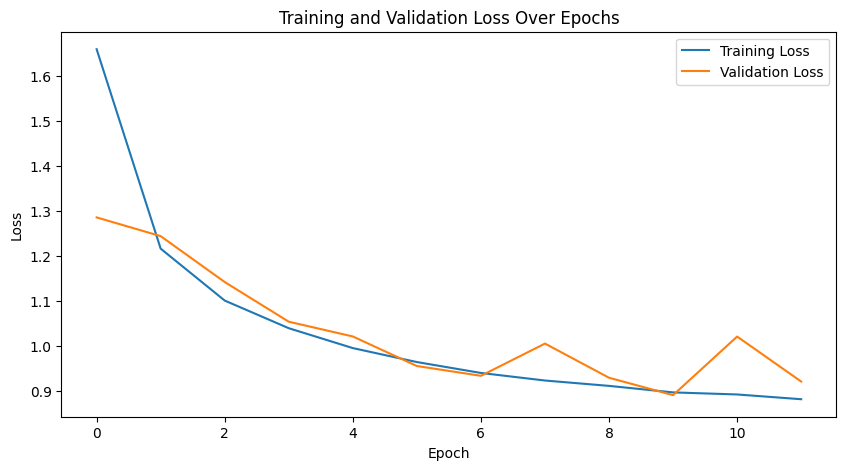

In [48]:
# Assuming 'train_losses' and 'valid_losses' are Python lists that contain the loss values for each epoch
# Here's the code to plot them together:

import matplotlib.pyplot as plt


# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

# Title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Legend
plt.legend()

# Show the plot
plt.show()


In [72]:
checkpoint = torch.load('my_checkpoint.pth.tar')  # Make sure the file path is correct

# Update model and optimizer from the checkpoint
model.load_state_dict(checkpoint['state_dict'])
# train_losses=checkpoint['train_losses'] ,
# valid_losses= checkpoint['valid_losses']

<All keys matched successfully>

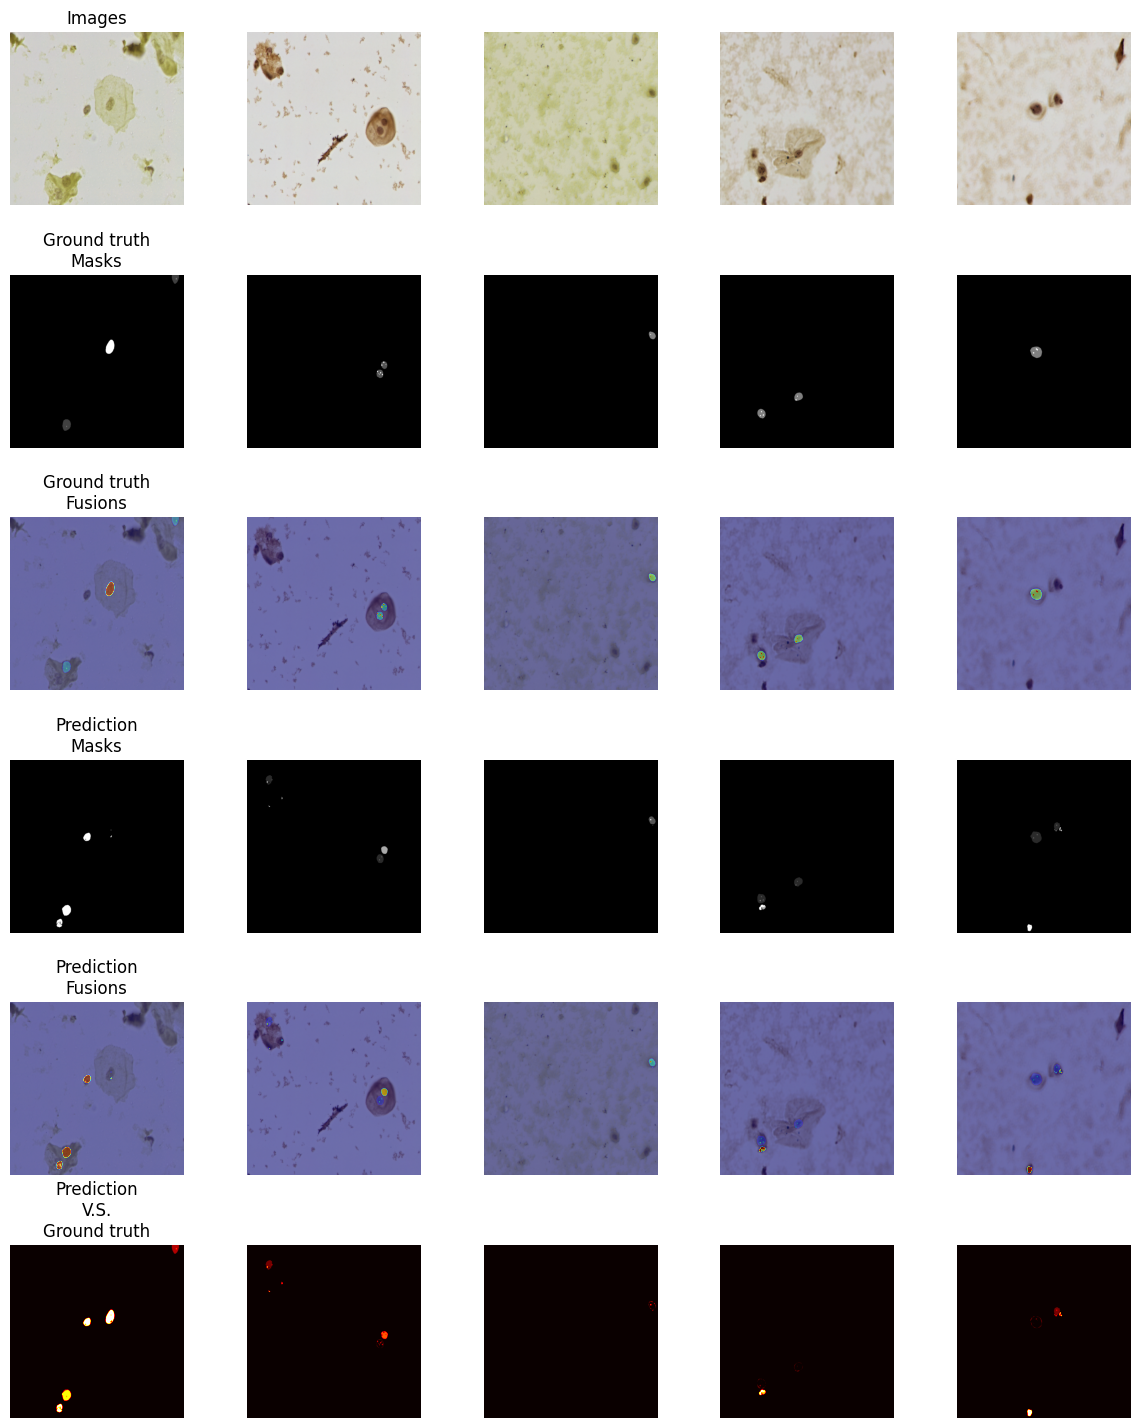

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Assuming 'model' is your trained semantic segmentation model
# and 'test_dataset' is a PyTorch Dataset with your images and ground truth masks.

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Disable gradient calculations
with torch.no_grad():
    # Prepare a figure with subplots
    fig, axs = plt.subplots(6, 5, figsize=(15, 18))  # 6 rows for the categories, 5 columns for the number of images
    fig.subplots_adjust(hspace=0.4, wspace=0.1)

    # Loop over a batch of images from the test dataset
    for i in range(5):  # Adjust the range for the number of images you want to visualize
        # Get an image and its corresponding ground truth mask
        j = random.randint(0, 1870) 
        image, gt_mask = test_dataset[j]  # Modify to access your test dataset correctly
        image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device
        output = model(image)  # Get model prediction

        # Apply softmax to get probabilities and then argmax to get the predicted class
        probabilities = torch.softmax(output, dim=1)
        predicted_mask = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()

        # Convert the image tensor to numpy for visualization
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        
        # Visualize original image
        axs[0, i].imshow(image_np)
        axs[0, i].axis('off')

        # Visualize ground truth mask
        axs[1, i].imshow(gt_mask.squeeze(), cmap='gray')
        axs[1, i].axis('off')

        # Visualize ground truth fusion
        axs[2, i].imshow(image_np)
        axs[2, i].imshow(gt_mask.squeeze(), cmap='jet', alpha=0.5)
        axs[2, i].axis('off')

        # Visualize predicted mask
        axs[3, i].imshow(predicted_mask, cmap='gray')
        axs[3, i].axis('off')

        # Visualize predicted fusion
        axs[4, i].imshow(image_np)
        axs[4, i].imshow(predicted_mask, cmap='jet', alpha=0.5)
        axs[4, i].axis('off')

        # Visualize prediction vs. ground truth
        difference = np.abs(gt_mask.squeeze() - predicted_mask)
        axs[5, i].imshow(difference, cmap='hot')
        axs[5, i].axis('off')

    # Set titles for the first column
    axs[0, 0].set_title('Images')
    axs[1, 0].set_title('Ground truth\nMasks')
    axs[2, 0].set_title('Ground truth\nFusions')
    axs[3, 0].set_title('Prediction\nMasks')
    axs[4, 0].set_title('Prediction\nFusions')
    axs[5, 0].set_title('Prediction\nV.S.\nGround truth')

    plt.show()


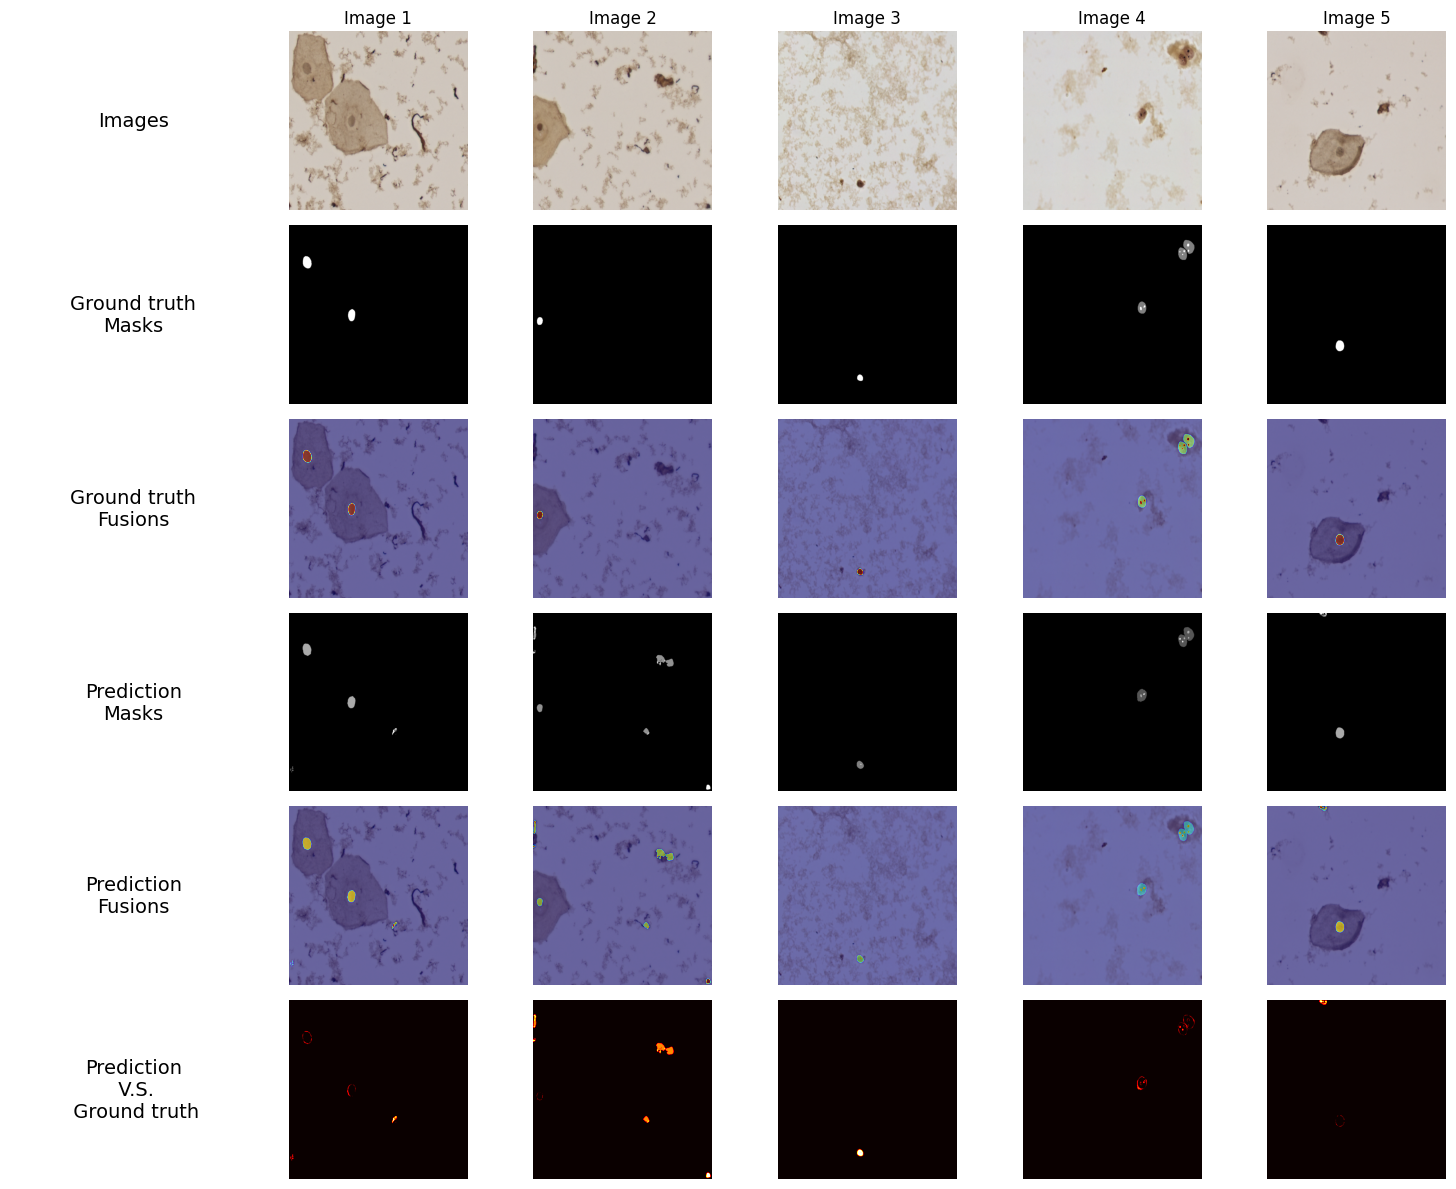

In [91]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision.transforms.functional import to_pil_image

model.eval()
imagelist=[]
# Disable gradient calculations
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create a figure for plotting
    fig = plt.figure(figsize=(15, 12))
    # Create a GridSpec layout
    gs = gridspec.GridSpec(6, 6, figure=fig)

    # Define the titles for each row
    title_labels = ['Images', 'Ground truth\nMasks', 'Ground truth\nFusions', 
                    'Prediction\nMasks', 'Prediction\nFusions', 'Prediction\n V.S.\n Ground truth']

    # Loop over the number of images you want to visualize
    for j in range(5):  # Adjust the range for the number of images you want to visualize
        # Get an image and its corresponding ground truth mask from the dataset
        idx = random.randint(0, 1869)
        image, gt_mask = test_dataset[idx]  # Modify to access your test dataset correctly
        image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device
        output = model(image)  # Get model prediction

        # Apply softmax to get probabilities and then argmax to get the predicted class
        probabilities = torch.softmax(output, dim=1)
        predicted_mask = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()

        # Convert the image tensor to PIL Image for visualization
        image_pil = to_pil_image(image.squeeze(0).cpu())
  
        for i in range(6):
            ax = plt.subplot(gs[i, j + 1])
            if i == 0:  # First row - Original images
                ax.imshow(image_pil)
                ax.set_title(f'Image {j+1}')
            elif i == 1:  # Second row - Ground truth masks
                ax.imshow(gt_mask.squeeze(), cmap='gray')
            elif i == 2:  # Third row - Ground truth fusions
                ax.imshow(image_pil)
                ax.imshow(gt_mask.squeeze(), cmap='jet', alpha=0.5)
            elif i == 3:  # Fourth row - Predicted masks
                ax.imshow(predicted_mask, cmap='gray')
            elif i == 4:  # Fifth row - Predicted fusions
             
                ax.imshow(image_pil)
                ax.imshow(predicted_mask, cmap='jet', alpha=0.5)
            elif i == 5:  # Sixth row - Prediction V.S. Ground truth
#                 difference = np.abs(gt_mask.squeeze().cpu().numpy() - predicted_mask)
                difference = np.abs(gt_mask.squeeze() - predicted_mask)
                ax.imshow(difference, cmap='hot')
            ax.axis('off')

    # Add titles to the left of the first image in each row
    for i, label in enumerate(title_labels):
        fig.add_subplot(gs[i, 0])
        plt.text(0.5, 0.5, label, rotation=0, fontsize=14, ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


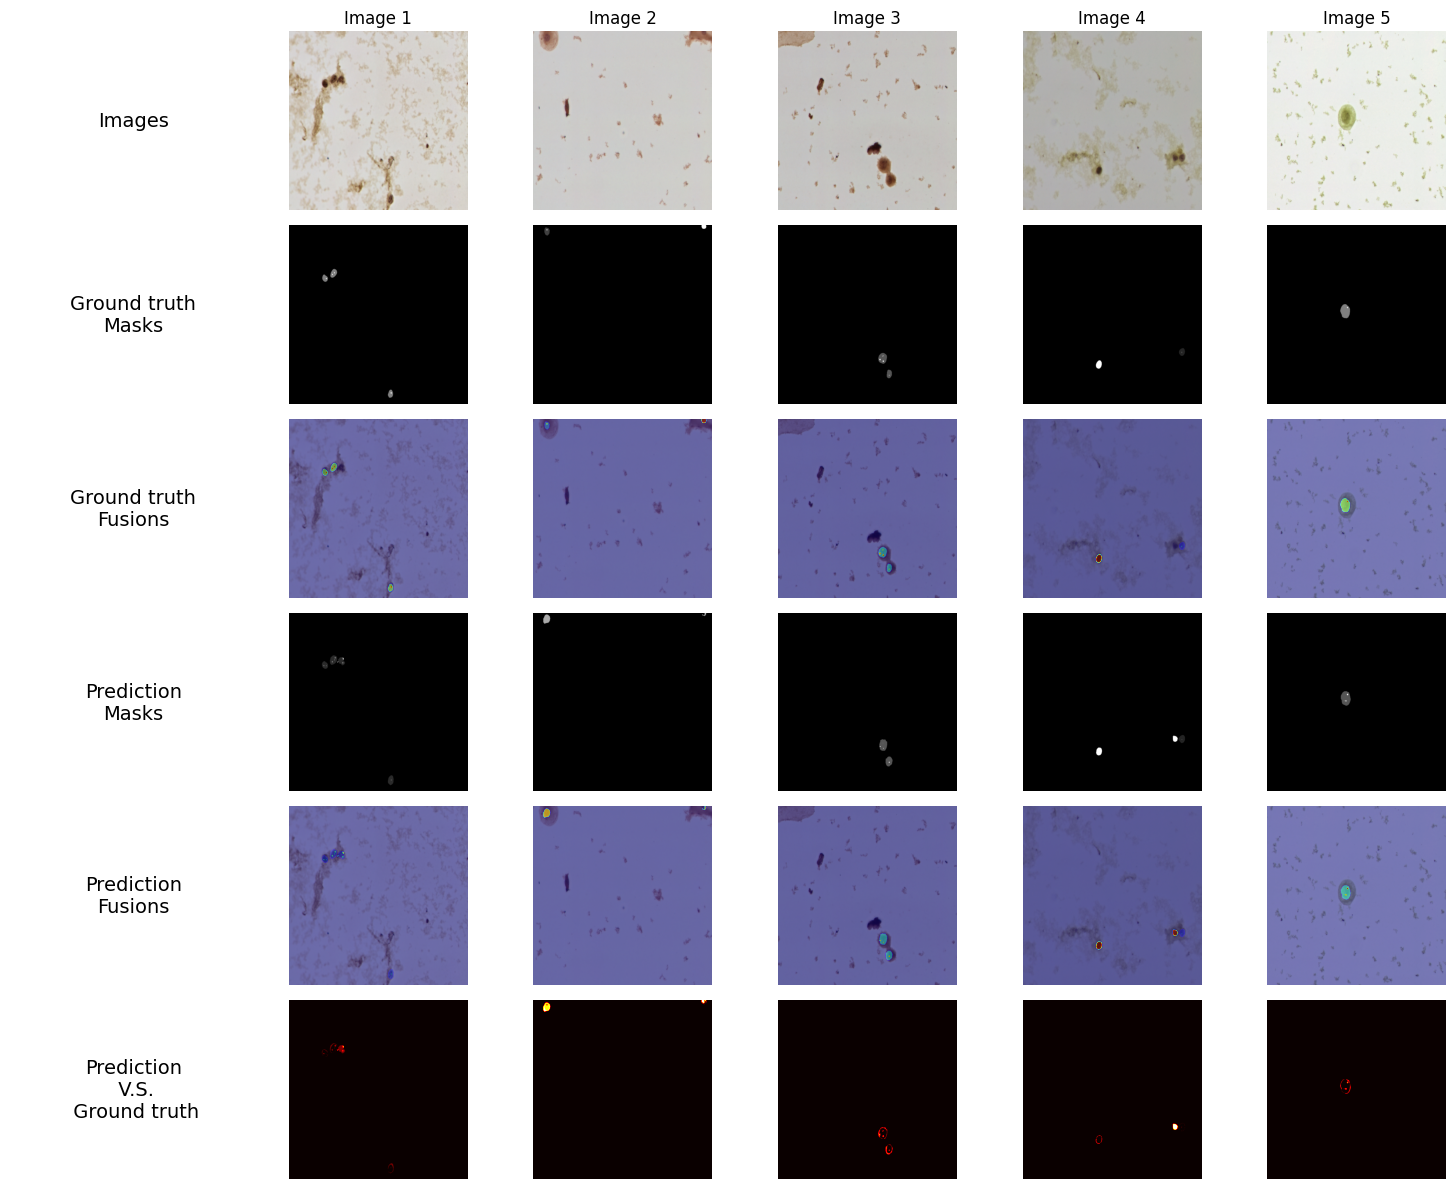

In [112]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision.transforms.functional import to_pil_image

model.eval()
imagelist=[]
# Disable gradient calculations
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create a figure for plotting
    fig = plt.figure(figsize=(15, 12))
    # Create a GridSpec layout
    gs = gridspec.GridSpec(6, 6, figure=fig)

    # Define the titles for each row
    title_labels = ['Images', 'Ground truth\nMasks', 'Ground truth\nFusions', 
                    'Prediction\nMasks', 'Prediction\nFusions', 'Prediction\n V.S.\n Ground truth']

    # Loop over the number of images you want to visualize
    for j in range(5):  # Adjust the range for the number of images you want to visualize
        # Get an image and its corresponding ground truth mask from the dataset
        idx = random.randint(0, 1869)
        image, gt_mask = test_dataset[idx]  # Modify to access your test dataset correctly
        image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device
        output = model(image)  # Get model prediction

        # Apply softmax to get probabilities and then argmax to get the predicted class
        probabilities = torch.softmax(output, dim=1)
        predicted_mask = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()

        # Convert the image tensor to PIL Image for visualization
        image_pil = to_pil_image(image.squeeze(0).cpu())
  
        for i in range(6):
            ax = plt.subplot(gs[i, j + 1])
            if i == 0:  # First row - Original images
                ax.imshow(image_pil)
                ax.set_title(f'Image {j+1}')
            elif i == 1:  # Second row - Ground truth masks
                ax.imshow(gt_mask.squeeze(), cmap='gray')
            elif i == 2:  # Third row - Ground truth fusions
                ax.imshow(image_pil)
                ax.imshow(gt_mask.squeeze(), cmap='jet', alpha=0.5)
            elif i == 3:  # Fourth row - Predicted masks
                ax.imshow(predicted_mask, cmap='gray')
            elif i == 4:  # Fifth row - Predicted fusions
             
                ax.imshow(image_pil)
                ax.imshow(predicted_mask, cmap='jet', alpha=0.5)
            elif i == 5:  # Sixth row - Prediction V.S. Ground truth
#                 difference = np.abs(gt_mask.squeeze().cpu().numpy() - predicted_mask)
                difference = np.abs(gt_mask.squeeze() - predicted_mask)
                ax.imshow(difference, cmap='hot')
            ax.axis('off')

    # Add titles to the left of the first image in each row
    for i, label in enumerate(title_labels):
        fig.add_subplot(gs[i, 0])
        plt.text(0.5, 0.5, label, rotation=0, fontsize=14, ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


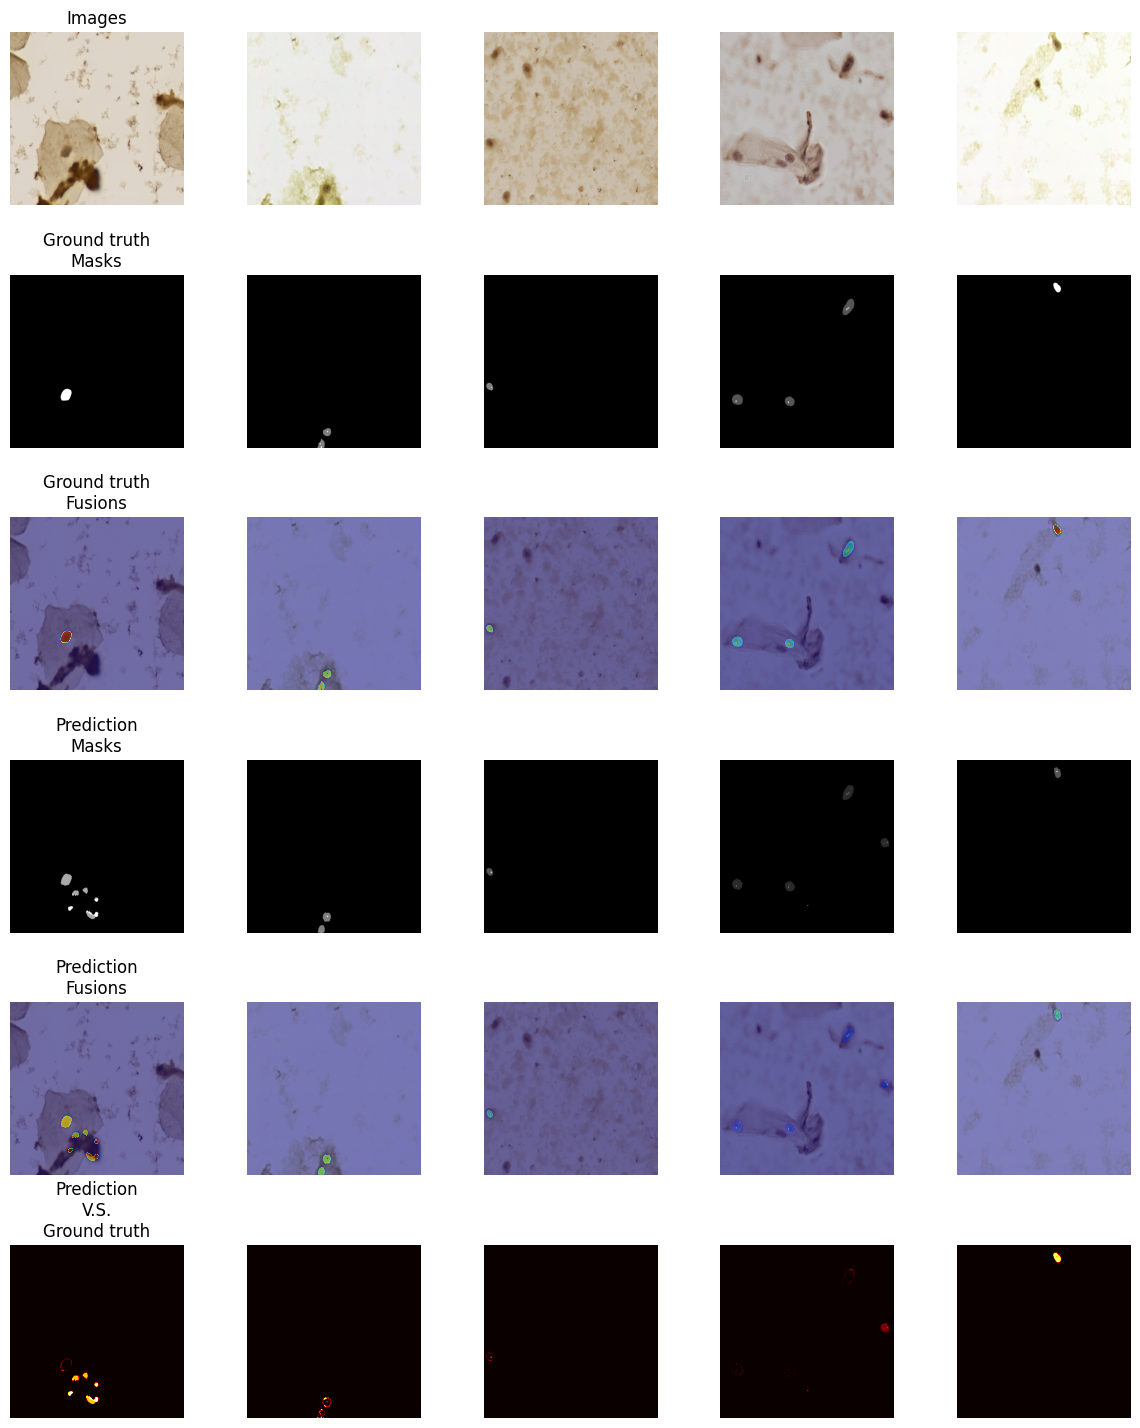

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Assuming 'model' is your trained semantic segmentation model
# and 'test_dataset' is a PyTorch Dataset with your images and ground truth masks.

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Disable gradient calculations
with torch.no_grad():
    # Prepare a figure with subplots
    fig, axs = plt.subplots(6, 5, figsize=(15, 18))  # 6 rows for the categories, 5 columns for the number of images
    fig.subplots_adjust(hspace=0.4, wspace=0.1)

    # Loop over a batch of images from the test dataset
    for i in range(5):  # Adjust the range for the number of images you want to visualize
        # Get an image and its corresponding ground truth mask
        j = random.randint(0, 1870) 
        image, gt_mask = test_dataset[j]  # Modify to access your test dataset correctly
        image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device
        output = model(image)  # Get model prediction

        # Apply softmax to get probabilities and then argmax to get the predicted class
        probabilities = torch.softmax(output, dim=1)
        predicted_mask = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()

        # Convert the image tensor to numpy for visualization
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        
        # Visualize original image
        axs[0, i].imshow(image_np)
        axs[0, i].axis('off')

        # Visualize ground truth mask
        axs[1, i].imshow(gt_mask.squeeze(), cmap='gray')
        axs[1, i].axis('off')

        # Visualize ground truth fusion
        axs[2, i].imshow(image_np)
        axs[2, i].imshow(gt_mask.squeeze(), cmap='jet', alpha=0.5)
        axs[2, i].axis('off')

        # Visualize predicted mask
        axs[3, i].imshow(predicted_mask, cmap='gray')
        axs[3, i].axis('off')

        # Visualize predicted fusion
        axs[4, i].imshow(image_np)
        axs[4, i].imshow(predicted_mask, cmap='jet', alpha=0.5)
        axs[4, i].axis('off')

        # Visualize prediction vs. ground truth
        difference = np.abs(gt_mask.squeeze() - predicted_mask)
        axs[5, i].imshow(difference, cmap='hot')
        axs[5, i].axis('off')

    # Set titles for the first column
    axs[0, 0].set_title('Images')
    axs[1, 0].set_title('Ground truth\nMasks')
    axs[2, 0].set_title('Ground truth\nFusions')
    axs[3, 0].set_title('Prediction\nMasks')
    axs[4, 0].set_title('Prediction\nFusions')
    axs[5, 0].set_title('Prediction\nV.S.\nGround truth')

    plt.show()


In [100]:
metrics_calculator = SegmentationMetrics(num_classes=8)
total_pixel_accuracy = 0
total_mean_pixel_accuracy = 0
total_iou = 0
total_dice = 0
total_samples = 0
for i, data in enumerate(test_loader):
    images, true_masks = data
    images = images.to(device)
    true_masks = true_masks.to(device)

    with torch.no_grad():
        # Get model predictions
        masks_pred = model(images)

        # Calculate metrics
        batch_metrics = metrics_calculator.evaluate(masks_pred, true_masks)
        total_pixel_accuracy += batch_metrics['Pixel Accuracy'] * images.size(0)
        total_mean_pixel_accuracy += batch_metrics['Mean Pixel Accuracy'] * images.size(0)
        total_iou += batch_metrics['Mean IoU'] * images.size(0)
        total_dice += batch_metrics['Dice Coefficient'] * images.size(0)
        total_samples += images.size(0)
# for metric_name, metric_value in metrics.items():
#     print(f"{metric_name}: {metric_value}")
    
average_pixel_accuracy = total_pixel_accuracy / total_samples
average_mean_pixel_accuracy = total_mean_pixel_accuracy / total_samples
average_iou = total_iou / total_samples
average_dice = total_dice / total_samples

# Print the average metrics
print(f"Average Pixel Accuracy: {average_pixel_accuracy:.4f}")
print(f"Average Mean Pixel Accuracy: {average_mean_pixel_accuracy:.4f}")
print(f"Average Mean IoU: {average_iou:.4f}")
print(f"Average Dice Coefficient: {average_dice:.4f}")

Average Pixel Accuracy: 0.9931
Average Mean Pixel Accuracy: 0.9931
Average Mean IoU: 0.3531
Average Dice Coefficient: 0.4741
